![My Image](https://raw.githubusercontent.com/ralf-42/Image/main/genai-banner-2.jpg)

<p><font size="5" color='grey'> <b>
Retrieval Augmented Generation
</b></font> </br></p>


---

In [ ]:
#@title
#@markdown   <p><font size="4" color='green'>  Colab-Umfeld</font> </br></p>
# Installierte Python Version
import sys
print(f"Python Version: ",sys.version)

# Installierte LangChain Bibliotheken
print()
print("Installierte LangChain Bibliotheken:")
!pip list | grep '^langchain'
# Unterdrückt die "DeprecationWarning" von LangChain für die Memory-Funktionden
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning, module="langsmith.client")

In [ ]:
#@title
#@markdown   <p><font size="4" color='green'>  SetUp API-Keys (setup_api_keys)</font> </br></p>
def setup_api_keys():
    """Konfiguriert alle benötigten API-Keys aus Google Colab userdata"""
    from google.colab import userdata
    import os
    from os import environ

    # Dictionary der benötigten API-Keys
    keys = {
        'OPENAI_API_KEY': 'OPENAI_API_KEY',
        'HF_TOKEN': 'HF_TOKEN',
        # Weitere Keys bei Bedarf
    }

    # Keys in Umgebungsvariablen setzen
    for env_var, key_name in keys.items():
        environ[env_var] = userdata.get(key_name)

    return {k: environ[k] for k in keys.keys()}

# Verwendung
all_keys = setup_api_keys()
# Bei Bedarf einzelne Keys direkt zugreifen
# WEATHER_API_KEY = all_keys['WEATHER_API_KEY']

# 1 | Übersicht
---


<p><font color='black' size="5">
Einführung in Retrieval-Augmented Generation (RAG)
</font></p>



Große Sprachmodelle (LLMs), wie sie in LangChain eingebunden sind, bieten leistungsstarke Möglichkeiten zur Verarbeitung und Analyse umfangreicher Textdaten. Sie eignen sich besonders für Aufgaben, die eine Extraktion und ein tiefgehendes Verständnis von Informationen erfordern, da sie in der Lage sind, auf Grundlage eines gegebenen Dokuments präzise Antworten auf Fragen zu generieren.

Ein wichtiger Ansatz zur **dokumentengestützten** Beantwortung von Fragen in Kombination mit LLMs ist die sogenannte Retrieval-Augmented Generation (RAG). Diese Methode verbindet die Vorteile klassischer Informationsabrufsysteme mit den generativen Fähigkeiten moderner Sprachmodelle. Die Funktionsweise von RAG lässt sich in drei Hauptphasen unterteilen:

1. **Abrufphase:** Zunächst sucht das RAG-System relevante Dokumente oder Textsegmente aus einer großen Sammlung heraus. Dabei wird geprüft, welche Inhalte eine hohe inhaltliche Übereinstimmung mit der gestellten Frage aufweisen. Ziel ist es, relevante Belege für die spätere Antwort zu finden.
2. **Anreicherungsphase:** Die identifizierten Dokumente werden als zusätzlicher Kontext in das Sprachmodell integriert. Dieser Schritt stellt sicher, dass das Modell Zugriff auf spezifische Informationen hat, die in seinem vordefinierten Wissen möglicherweise nicht enthalten sind.
3. **Generierungsphase:** Mithilfe des bereitgestellten Kontexts erstellt das Sprachmodell eine kohärente Antwort. Es kombiniert die abgerufenen Inhalte mit seinem Sprachverständnis, um eine präzise und gut formulierte Antwort zu liefern.

Durch die Verknüpfung von Informationsabruf und Textgenerierung erhöht RAG die Fähigkeit von LLMs, fundierte und kontextbezogene Antworten zu liefern. Besonders nützlich ist dieser Ansatz, wenn relevante Informationen nicht direkt im vorab trainierten Modellwissen vorhanden sind und daher externe Quellen herangezogen werden müssen. Die Integration von RAG in LangChain ermöglicht eine effektive und flexible Lösung für die Beantwortung von Fragen auf Basis von Dokumenten, was ein differenziertes Verständnis und präzise Antworten in verschiedenen Anwendungsbereichen gewährleistet.


<p><font color='black' size="5">
RAG-Prozess Schritt für Schritt
</font></p>

[RAG-Visualizer](https://claude.site/artifacts/e54ef5f2-0ba0-4468-9315-18f7c1c86c4b)

In [ ]:
# Schritt 0: Install - requirements.txt erstellen
%%writefile requirements.txt
# LangChain-Ökosystem
langchain-community>=0.0.16
langchain-openai>=0.0.5
langchain-chroma>=0.0.13
langchain-huggingface

# Tokenisierung und Textverarbeitung
tiktoken>=0.5.2
pypdf>=3.9.0
unstructured[all-docs]>=0.11.2

# API-Clients und Netzwerkkommunikation
openai==1.55.3
httpx==0.27.2
anyio==3.7.1

# Vector-Datenbank
chromadb

In [ ]:
# Schritt 0: Install - requirements.txt ausführen
!uv pip install --system --prerelease allow -q -r requirements.txt


Der erste Schritt besteht darin, eine Verbindung zu einem OpenAI-Sprachmodell herzustellen.

In [ ]:
# Schritt 1: Import
from langchain.document_loaders import PyPDFLoader
from langchain.indexes import VectorstoreIndexCreator
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_community.vectorstores.inmemory import InMemoryVectorStore
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

from IPython.display import Markdown, display

In [ ]:
# Schritt 2: Konstanten definieren
MODEL = "gpt-4o-mini"
TEMPERATURE = 0.2

In [ ]:
# Schritt 3: Chat-Komponenten initialisieren
llm = ChatOpenAI(model=MODEL, temperature=TEMPERATURE)

Nun werden mehrere PDF-Dokumente geladen, die anschließend für gezielte Abfragen genutzt werden können. Dabei können Fragen gestellt werden, die Informationen aus den Dokumenten enthalten, welche nicht Teil des ursprünglichen Sprachmodells sind. Um die PDFs effizient abfragen zu können, wird für jedes Dokument ein eigener Loader erstellt, sodass sie in einen Vektorspeicher überführt werden können.

Zunächst wird das PDF-Dokument über den **„PyPDFLoader“** aus der angegebenen URL („https://arxiv.org/pdf/1706.03762“) geladen.

In [ ]:
# Schritt 4: Dokumente laden
URLS = [
    "https://arxiv.org/pdf/1706.03762", # Attention is All You Need - 15 Seiten
    "https://arxiv.org/pdf/1810.04805", # BERT: Pre-training of Deep Bidirectional Transformers... - 16 Seiten
    "https://arxiv.org/pdf/2005.14165", # Language Models are Few-Shot Learners - 75 Seiten
    "https://arxiv.org/pdf/1910.10683"  # Exploring the Limits of Transfer Learning  ... - 67 Seiten
]

loaders = []

print("Starte das Laden der PDF-Dokumente...")

for url in URLS:
    print(f"Lesen: {url}")
    loader = PyPDFLoader(url)
    loaders.append(loader)

Als nächstes werden die Einbettungen aus den vier Dokumenten in [ChromaDB](https://docs.trychroma.com/docs/overview/introduction) gespeichert. Diese Einbettungen dienen dazu, die Eingabeaufforderung mit relevanten Informationen aus den geladenen PDF-Dokumenten anzureichern.

In [ ]:
# Schritt 5: Vektorindex und -datenbank mit OpenAI Embeddings erstellen
print("Erstelle Vektorindex...")

embeddings_model = OpenAIEmbeddings()

index = VectorstoreIndexCreator(
    embedding=embeddings_model,
    vectorstore_cls=InMemoryVectorStore
).from_loaders(loaders)

Der Code verwendet `VectorstoreIndexCreator` von Langchain zur Erstellung eines Index aus mehreren PDF-Dokumenten. Der Standard-Chunking-Prozess von VectorstoreIndexCreator ist folgender:

+ **Dokumenten laden:** Die PyPDFLoader-Klasse lädt die PDF-Dateien von den gegebenen URLs. Jede PDF-Datei wird als Document-Objekt in Langchain geladen.

+ **Textaufteilung (Chunking):** VectorstoreIndexCreator verwendet intern einen TextSplitter, um die geladenen Dokumente in kleinere Chunks aufzuteilen. Standardmäßig wird der CharacterTextSplitter verwendet. Wenn keine anderen Parameter angegeben sind, teilt `CharacterTextSplitter` den Text anhand von bestimmten Trennzeichen (standardmäßig "\n\n", "\n", " ", "") in Chunks auf. Dabei wird versucht, die Chunks so zu gestalten, dass sie die eingestellte chunk_size (standardmäßig 4000 Zeichen) nicht überschreiten und eine gewisser chunk_overlap (standardmäßig 200 Zeichen) zwischen den Chunks besteht. Dies soll sicherstellen, dass wichtige Informationen nicht zwischen Chunks verloren gehen.

+ **Einbettungen erstellen:** Für jeden Chunk wird ein Embedding mit dem `OpenAIEmbeddings`-Modell erstellt. Diese Embeddings sind Vektordarstellungen der Textchunks.

+ **Vektor-Datenbank erstellen:** Die Text-Chunks und ihre entsprechenden Embeddings werden in einer Vektor-Datenbank (in diesem Fall InMemoryVectorStore) gespeichert. Diese Vektor-Datenbank ermöglicht später eine effiziente Suche nach ähnlichen Texten basierend auf den Embeddings.

Zusammenfassend lässt sich sagen:

Der Chunking-Prozess im angegebenen Code verwendet den Standard-CharacterTextSplitter mit einer Chunk-Größe von 4.000 Zeichen und einem Chunk-Overlap von 200 Zeichen. Das bedeutet, dass der Text aus den PDF-Dateien in Chunks von maximal 4.000 Zeichen aufgeteilt wird, wobei sich die Chunks um 200 Zeichen überschneiden, um Kontext zu erhalten.

Sobald die Einbettungen geladen sind, kann gezielt nach Informationen gesucht werden, die ausschließlich in den Dokumenten enthalten sind.

In [ ]:
# Schritt 6: Abfrage der Vektordatenbank
query = "Which figure demonstrates Scaled Dot-Product Attention?"
results = index.vectorstore.similarity_search(query)

# Ergebnisse ausgeben
display(Markdown("### 🧑Mensch:"))
display(Markdown(query))
display(Markdown("### 🤖KI:"))

best_result = results[0]  # Nimm nur das erste Dokument
best_text = f"**Beste Quelle:**\n\n{best_result.page_content}\n\n"
display(Markdown(best_text))

Dabei kann man sich auch die Quelle angeben lassen.

In [ ]:
# Abschnitt 6: Abfrage der Vektordatenbank
query = "Which figure demonstrates Scaled Dot-Product Attention?"
results = index.vectorstore.similarity_search(query)

# Ergebnisse ausgeben
display(Markdown("### 🧑Mensch:"))
display(Markdown(query))
display(Markdown("### 🤖KI:"))

best_result = results[0]  # Nimm nur das erste Dokument
best_text = f"**Beste Quelle:**\n\n{best_result.page_content}\n\n"
best_text += f"Quelle: {best_result.metadata.get('source', 'Keine Quelle angegeben')}"
display(Markdown(best_text))

Weitere Verarbeitung der Suchergebnisse mit einem LLM

In [ ]:
# Abschnitt 7: ... plus LLM Verarbeitung

# Die Abfrage definieren
query = "Which figure demonstrates Scaled Dot-Product Attention?"

# Ähnlichkeitssuche durchführen
results = index.vectorstore.similarity_search(query)

# Hilfreiche Funktion, um den Kontext zu formatieren
def format_docs(docs):
    return "\n\n".join([doc.page_content for doc in docs])

# Prompt für das LLM erstellen
prompt_template = """
Du bist ein hilfreicher Assistent, der Fragen basierend auf den bereitgestellten Kontext beantwortet.

Frage: {question}

Kontext:
{context}

Bitte antworte detailliert und basiere deine Antwort ausschließlich auf den bereitgestellten Kontext.
Wenn die Antwort nicht im Kontext enthalten ist, sage "Ich kann diese Frage basierend auf dem verfügbaren Kontext nicht beantworten."

Gebe abschliessend noch einen humorvollen Hinweis.

Antwort:
"""

# Prompt erstellen
prompt = PromptTemplate.from_template(prompt_template)

# Erstellen der RAG-Chain
rag_chain = (
    # Ein Dictionary mit den Inputs erstellen
    {
        "context": lambda x: format_docs(results),
        "question": lambda x: x
    }
    # Input in das Prompt-Template einfügen
    | prompt
    # An das LLM weitergeben
    | llm
    # Das Ergebnis als String extrahieren
    | StrOutputParser()
)

# Chain aufrufen
response = rag_chain.invoke(query)

# Ergebnisse ausgeben
display(Markdown("### 🧑Mensch:"))
display(Markdown(query))
display(Markdown("### 🤖KI:"))
display(Markdown(response))

# Optional: Zusätzlich auch die Quellen anzeigen
best_result = results[0]  # Nur das erste Dokument
source_info = f"**Quelle:** {best_result.metadata.get('source', 'Keine Quelle angegeben')}"
display(Markdown(source_info))


<p><font color='black' size="5">
Einschränkungen von RAG
</font></p>



LLM RAG kombiniert Sprachmodelle mit externem Datenabruf, um fehlendes Wissen aus spezialisierten oder proprietären Quellen zu ergänzen. Dies ist besonders nützlich in Bereichen wie Finanzen, Recht oder Technik, wo präzise und aktuelle Informationen erforderlich sind.

Wenn die zusätzlichen Daten jedoch bereits Allgemeinwissen sind, bringt RAG wenig Mehrwert. Da das Basismodell umfassend vortrainiert ist, kann es viele Anfragen ohne externe Erweiterung beantworten. Der unnötige Abruf bekannter Informationen führt zudem zu Ineffizienzen und erhöht den Rechenaufwand.

RAG sollte gezielt eingesetzt werden, insbesondere für domänenspezifische oder proprietäre Daten, die das Basismodell nicht abdeckt. In allgemeinen Wissensbereichen ist es meist überflüssig.

# 2 | DeepDive: Token & Chunks
---

<p><font color='blue' size="4">
Tokenizing
</font></p>

**Warum sind Tokenisierung und Chunking wichtig?**

Große Sprachmodelle (LLMs) wie GPT-3 oder BERT verarbeiten Text nicht als ganze Sätze oder Absätze, sondern als eine Folge von "Tokens". Tokenisierung und Chunking sind entscheidende Vorverarbeitungsschritte, die es ermöglichen, Texte effizient zu verarbeiten und die Leistung von KI-Modellen zu optimieren.



**Tokenisierung: Die Grundlage der Textverarbeitung**

Tokenisierung ist der Prozess, bei dem Text in kleinere Einheiten, sogenannte Tokens, zerlegt wird. Diese Tokens können Wörter, Teilwörter oder sogar einzelne Zeichen sein.

**Warum ist Tokenisierung wichtig?**

1. **Einheitliche Verarbeitung:** LLMs haben eine begrenzte Eingabelänge (z.B. 512 oder 1024 Tokens). Die Tokenisierung stellt sicher, dass Texte in einem einheitlichen Format vorliegen, das vom Modell verarbeitet werden kann.

2. **Bedeutungserfassung:** Viele Tokens repräsentieren semantische Einheiten, was dem Modell hilft, die Bedeutung des Textes besser zu erfassen.

3. **Effiziente Verarbeitung:** Tokenisierte Texte können effizienter verarbeitet und in numerische Vektoren umgewandelt werden, was für die Eingabe in neuronale Netze notwendig ist.


**Hilfe:**

1 DIN A4 Seite hat ca. 300 Worte und ca. 450 Token

<p><font color='blue' size="4">
Chunking
</font></p>

**Chunking: Texte in verdauliche Häppchen teilen**

Chunking ist der Prozess, bei dem längere Texte in kleinere, zusammenhängende Abschnitte (Chunks) aufgeteilt werden.

**Warum ist Chunking wichtig?**

1. **Verarbeitung langer Texte:** Da LLMs eine begrenzte Eingabelänge haben, ermöglicht Chunking die Verarbeitung von Texten, die länger als diese Grenze sind.

2. **Kontexterhaltung:** Durch geschicktes Chunking kann der relevante Kontext innerhalb eines Chunks erhalten bleiben, was für viele NLP-Aufgaben entscheidend ist.

3. **Effizienz:** Kleinere Chunks können parallel verarbeitet werden, was die Gesamtverarbeitungszeit reduzieren kann.



**Hauptansätze für Tokenisierung und Chunking**

1. **Wortbasierte Tokenisierung:** Teilt Text an Wortgrenzen. Einfach, aber nicht immer optimal für komplexe Sprachen oder technische Texte.

2. **Subword-Tokenisierung:** Zerlegt Wörter in häufig vorkommende Teilwörter. Beispiele sind BPE (Byte-Pair Encoding) oder WordPiece. Dies ist besonders nützlich für die Behandlung von unbekannten Wörtern und morphologisch reichen Sprachen.

3. **Zeichenbasierte Tokenisierung:** Betrachtet jedes Zeichen als separates Token. Nützlich für bestimmte Sprachen oder spezielle Anwendungen.

4. **Satzbasiertes Chunking:** Teilt Text in Sätze. Einfach und oft effektiv, kann aber Kontext zwischen Sätzen verlieren.

5. **Überlappende Chunks:** Erstellt Chunks mit Überlappungen, um Kontext an den Chunk-Grenzen zu erhalten.

6. **Semantisches Chunking:** Versucht, Chunks basierend auf Bedeutungseinheiten zu erstellen, was komplexer, aber oft effektiver für das Verständnis ist.

Durch die richtige Kombination von Tokenisierung und Chunking können wir Texte so vorbereiten, dass sie optimal von KI-Modellen verarbeitet werden können. Dies verbessert nicht nur die Leistung der Modelle, sondern ermöglicht auch die Verarbeitung von Texten beliebiger Länge in RAG-Systemen und anderen NLP-Anwendungen.

[Tokenizer](https://platform.openai.com/tokenizer)         
[ChunkViz](https://chunkviz.up.railway.app/)

Im nachfolgenden Code werden beide Schritte explizit ausgeführt.

**Tiktoken** ist eine Bibliothek für die Tokenisierung von Text, die speziell für OpenAI-Modelle entwickelt wurde. Hier sind die wichtigsten Eigenschaften und Funktionen:

**Grundlegende Funktionen:**

Tiktoken ist ein schneller BPE-Tokenisierer (Byte Pair Encoding), der für die Verwendung mit OpenAI-Modellen entwickelt wurde. Die Bibliothek ermöglicht es:

1. **Text in Tokens zu zerlegen**: Tokenisierung zerlegt Text in kleinere Teile, was Maschinen hilft, menschliche Sprache besser zu verstehen.

2. **Tokens zu zählen**: Durch die Verwendung von Tiktoken können Sie die Tokenzahl bestimmen, wodurch Sie sicherstellen können, dass Ihre Texteingabe innerhalb der Modellgrenzen bleibt und gleichzeitig die API-Nutzungskosten verwalten.

3. **Token wieder in Text umzuwandeln**: Die Bibliothek ermöglicht sowohl die Kodierung als auch die Dekodierung.

**Unterstützte Encodings:**

Tiktoken unterstützt verschiedene Encodings, darunter cl100k_base, p50k_base, r50k_base und das neuere o200k_base, die über die Funktion tiktoken.encoding_for_model() abgerufen werden können.

Jedes OpenAI-Modell verwendet ein spezifisches Encoding. Zum Beispiel verwendet GPT-4o das "o200k_base"-Encoding, während GPT-4 und GPT-3.5-Turbo das "cl100k_base"-Encoding verwenden.

**Verwendung in der Praxis:**

Der Hauptzweck von Tiktoken in der Entwicklung liegt in:

1. **Kontextfensterverwaltung**: In Englisch reichen Tokens typischerweise von einem Zeichen bis zu einem Wort (z.B. "t" oder " great"). Leerzeichen werden normalerweise mit dem Beginn von Wörtern gruppiert.

2. **Kostenabschätzung**: Da die Abrechnung der OpenAI-API auf der Anzahl der verarbeiteten Tokens basiert, ermöglicht die vorherige Tokenisierung Ihres Textes die Schätzung der Kosten Ihrer API-Nutzung.

3. **Text-Splitting für RAG-Systeme**: Tiktoken wird häufig verwendet, um Dokumente in Chunks aufzuteilen, die dann in Vektordatenbanken indiziert werden.


In [ ]:
import tiktoken
from langchain.document_loaders import PyPDFLoader

CHUNK_SIZE=500
CHUNK_OVERLAP=50

# Tokenizer initialisieren
tokenizer = tiktoken.get_encoding("cl100k_base")

Die Zeile `tokenizer = tiktoken.get_encoding("cl100k_base")` erstellt einen Tokenizer, der die "cl100k_base"-Codierung verwendet, welche speziell für neuere OpenAI-Modelle wie GPT-4 und einige Versionen von GPT-3.5-Turbo entwickelt wurde.

Der Tokenizer hat mehrere wichtige Funktionen:

1. **Textsegmentierung**: Er zerlegt Text in sogenannte "Tokens" - die grundlegenden Einheiten, die von LLMs verarbeitet werden. Diese können einzelne Zeichen, Teilwörter oder ganze Wörter sein.

2. **Vokabular-Mapping**: Er wandelt diese Textteile in numerische IDs um, die das Modell verstehen kann.

3. **Längenbestimmung**: Er hilft dabei, die Anzahl der Tokens in einem Text zu zählen, was wichtig ist, um die Kontextlänge zu überwachen und sicherzustellen, dass sie unter dem Maximallimit (z.B. 4096 oder 8192 Tokens) bleibt.

Die "cl100k_base"-Codierung ist besonders wichtig, weil sie:

- Vom GPT-4 Modell verwendet wird
- Eine Vokabulargröße von etwa 100.000 Token hat (daher der Name)
- Effizienter mit verschiedenen Sprachen und Zeichensätzen umgehen kann
- Von OpenAI für ihre neuesten Modelle empfohlen wird

Im praktischen Einsatz wird dieser Tokenizer häufig verwendet, um:
- Die Länge von Texten zu messen (für Preisberechnung oder Kontextfenster-Management)
- Texte für das Chunking in Vektorendatenbanken vorzubereiten
- Die Tokens zu zählen, bevor Text an ein LLM gesendet wird

Dieser spezifische Tokenizer ist besonders wichtig im OpenAI-Ökosystem und wird oft in LangChain-Anwendungen verwendet, um sicherzustellen, dass Textdaten korrekt für die Verarbeitung durch moderne GPT-Modelle vorbereitet werden.

In [ ]:
class TokenBasedTextSplitter(TextSplitter):
    def __init__(self, chunk_size: int, chunk_overlap: int):
        self.tokenizer = tokenizer
        self.chunk_size = chunk_size
        self.chunk_overlap = chunk_overlap

    def split_text(self, text: str) -> list[str]:
        tokens = self.tokenizer.encode(text)
        chunks = []

        start = 0
        while start < len(tokens):
            end = start + self.chunk_size
            chunk_tokens = tokens[start:end]
            chunk_text = self.tokenizer.decode(chunk_tokens)
            chunks.append(chunk_text)
            start += (self.chunk_size - self.chunk_overlap)

        return chunks

Die `TokenBasedTextSplitter`-Klasse ist ein spezieller Text-Splitter, der Text in Chunks (Abschnitte) basierend auf Token-Zählungen anstatt auf einfachen Zeichenzählungen aufteilt. Hier ist die Funktionsweise im Detail:

1. **Initialisierung**: Der Konstruktor (`__init__`) nimmt drei Parameter auf:
   - `self.tokenizer`: Der vorher definierte tiktoken-Tokenizer (cl100k_base)
   - `self.chunk_size`: Die maximale Anzahl von Tokens pro Chunk
   - `self.chunk_overlap`: Die Anzahl der Tokens, die zwischen benachbarten Chunks überlappen sollen

2. **Methode `split_text`**: Diese Methode zerteilt einen Text in Chunks und funktioniert so:
   - Der Text wird zuerst mit dem Tokenizer in eine Liste von Token-IDs umgewandelt
   - Dann durchläuft die Methode diese Token-Liste mit einer Schleife:
     - Sie nimmt jeweils einen Abschnitt von `chunk_size` Tokens
     - Dieser Abschnitt wird zurück in Text decodiert
     - Der Text wird zur Liste der Chunks hinzugefügt
     - Der Startpunkt wird um `chunk_size - chunk_overlap` weiterbewegt (das ermöglicht die Überlappung)

Die Vorteile dieses Token-basierten Splitters gegenüber zeichenbasierten Splittern sind:

1. **Modellangepasst**: Die Aufteilung erfolgt exakt nach der gleichen Tokenisierung, die das LLM verwendet
2. **Größenkontrolle**: Die Chunks haben eine präzise kontrollierte Tokenzahl, was wichtig ist, da LLMs Limits für Eingabetokens haben
3. **Semantische Kohärenz**: Durch die Überlappung wird sichergestellt, dass der Kontext zwischen den Chunks erhalten bleibt

Dieser Splitter ist besonders nützlich bei der Vorbereitung von Texten für:
- Vektordatenbanken und Embeddings
- Chunking für RAG-Systeme (Retrieval-Augmented Generation)
- Verarbeitung langer Dokumente für LLMs mit begrenzter Kontextlänge

Der `chunk_overlap`-Parameter ist besonders wichtig, da er hilft, semantische Kontinuität zwischen den Chunks zu bewahren, was die Qualität von Embeddings und Retrievals verbessern kann.

In [ ]:
# URLs definieren
URLS = [
    "https://arxiv.org/pdf/1706.03762",
]

# TokenBasedTextSplitter initialisieren
splitter = TokenBasedTextSplitter(chunk_size=CHUNK_SIZE, chunk_overlap=CHUNK_OVERLAP)

# Dokumente laden und chunken
for url in URLS:
    print(f"Verarbeite: {url}")
    loader = PyPDFLoader(url)
    pages = loader.load()

    for i, page in enumerate(pages):
        chunks = splitter.split_text(page.page_content)
        print(f"  Seite {i+1}: {len(chunks)} Chunks")
        for j, chunk in enumerate(chunks[:2], 1):  # Zeige nur die ersten 2 Chunks pro Seite
            print(f"    Chunk {j}: {len(tokenizer.encode(chunk))} Tokens")

# 3 | DeepDive: Einbettungen
---

Einbettungen stellen eine KI-optimierte Repräsentation verschiedener Datentypen dar und eignen sich daher besonders für den Einsatz in einer Vielzahl KI-gestützter Tools und Algorithmen. Sie erfassen die wesentlichen Merkmale von Texten, Bildern und auch von Audio- und Videodaten.

Ein Einbettungsmodell verarbeitet Eingangsdaten und wandelt sie in numerische Vektoren um. Die Architektur des Modells sorgt dafür, dass ähnliche Inhalte – beispielsweise Texte mit verwandter Bedeutung oder visuell ähnliche Bilder – im Vektorraum näher beieinander liegen, während sich unähnliche Daten weiter voneinander entfernt befinden.

Ein **Embedding** ist ein Vektor aus Gleitkommazahlen, der Ähnlichkeiten zwischen Texten misst. Kleinere Abstände zwischen Vektoren bedeuten eine stärkere inhaltliche Nähe.

OpenAI bietet zwei Einbettungsmodelle an:
- **text-embedding-3-small**
- **text-embedding-3-large**

**Unterschiede und Auswahlkriterien:**

| Kriterium         | text-embedding-3-small | text-embedding-3-large |
|------------------|----------------------|----------------------|
| **Genauigkeit & Leistung** | Weniger detailliert, aber für viele Aufgaben ausreichend | Erfasst komplexere Zusammenhänge, ideal für anspruchsvolle NLP-Aufgaben |
| **Rechenaufwand** | Effizient, benötigt weniger Ressourcen | Höherer Speicher- und Rechenbedarf |
| **Latenz & Geschwindigkeit** | Schnellere Verarbeitung, geringe Latenz | Höhere Latenz, nicht ideal für Echtzeit-Anwendungen |
| **Kosten** | Kostengünstiger, ideal für skalierbare Anwendungen | Teurer in Betrieb und Bereitstellung |
| **Anwendungsfälle** | Chatbots, Echtzeitsysteme, einfache Textverarbeitung | Semantische Analyse, komplexe NLP-Aufgaben, KI-Forschung |



**Fazit**:  
- **Large**: Wenn hohe Präzision, detailliertes Sprachverständnis und ausreichend Ressourcen vorhanden sind.  
- **Small**: Wenn Effizienz, niedrige Kosten und schnelle Reaktionszeiten im Vordergrund stehen.  

Die Wahl des Modells hängt von den spezifischen Anforderungen der Anwendung ab.


<p><font color='black' size="5">
Instanz eines Einbettungsmodells
</font></p>

Hier ist ein Beispiel für die Erstellung einer Instanz mit text-embedding-3-small.

In [ ]:
from langchain_openai import OpenAIEmbeddings
embeddings_model = OpenAIEmbeddings(model="text-embedding-3-small")

<p><font color='black' size="5">
Vektoren
</font></p>

Ein Vektor ist eine mathematische Darstellung, die eine Menge von Zahlen in einer bestimmten Reihenfolge speichert. In einem Einbettungsmodell wird jeder Text – sei es ein einzelnes Wort, ein Satz oder ein ganzer Absatz – als Vektor in einem hochdimensionalen Raum dargestellt. Diese Darstellung ermöglicht es, Ähnlichkeiten zwischen Texten mathematisch zu berechnen.

**Wortvektoren**
Wenn ein Einbettungsmodell ein einzelnes Wort in einen Vektor umwandelt, geschieht dies auf Basis der Bedeutung und des Kontexts des Wortes. Das bedeutet, dass Wörter mit ähnlicher Bedeutung oder Verwendung in der Sprache ähnliche Vektoren erhalten. Ein Beispiel:

- Das Wort „Katze“ könnte in einem 3D-Raum (vereinfacht dargestellt) als Vektor **(0.5, 1.2, -0.3)** erscheinen.
- Das Wort „Hund“ könnte einen ähnlichen Vektor haben, z. B. **(0.6, 1.1, -0.2)**, da beide Begriffe semantisch verwandt sind.

Dagegen hätte ein völlig anderes Wort wie „Auto“ einen weit entfernten Vektor, z. B. **(2.3, -0.4, 1.7)**, da es eine ganz andere Bedeutung hat.


In [ ]:
vektor1 = embeddings_model.embed_query("Hund")
vektor2 = embeddings_model.embed_query("Ein Hund läuft über die Straße.")

print(type(vektor1))

Die Ausgabe besteht lediglich aus einer gewöhnlichen Python-Liste, die jedoch eine erhebliche Länge aufweist.

In [ ]:
print(len(vektor1))
print(len(vektor2))

Die Länge dieser Zeichenfolge bleibt bei allen Abfragen desselben Modells konstant. Obwohl die größere Modellversion in der Lage ist, qualitativ bessere Vektoren zur Unterscheidung von Zeichenfolgen zu erzeugen, bedeutet dies nicht zwangsläufig, dass eine größere Vektorlänge erforderlich ist, um diese Verbesserung zu erzielen. Dieses Konzept ist komplex und bedarf weiterer Untersuchung.

Betrachtet man die eigentliche Liste, erkennt man, dass sie lediglich eine Sammlung von Zahlen enthält. Nachfolgend sind die ersten zehn Elemente dargestellt.

In [ ]:
print(vektor1[:5]) # Hund
print(vektor2[:5]) # Ein Hund läuft über die Straße.

<p><font color='black' size="5">
 Vektoren vergleichen
</font></p>

In der Mathematik gibt es verschiedene Methoden, um Vektoren miteinander zu vergleichen. Einige der gängigsten Ansätze sind:


* **Euklidische Distanz**: Gibt die direkte Entfernung zwischen zwei Vektoren an und wird häufig in Clustering-Methoden oder Algorithmen zum nächsten Nachbarn im maschinellen Lernen verwendet.

* **Kosinus-Ähnlichkeit**: Berechnet den Kosinus des Winkels zwischen zwei Vektoren, wobei die Orientierung stärker gewichtet wird als die Größe. Diese Technik ist besonders verbreitet in Bereichen wie Text Mining und der Informationssuche, um Dokumente auf Ähnlichkeit zu prüfen.

* **Manhattan-Distanz**: Addiert die absoluten Differenzen der Komponenten zweier Vektoren. Diese Methode wird vor allem in gitterbasierten Pfadsuchalgorithmen sowie in bestimmten maschinellen Lernanwendungen eingesetzt.

Laut einer Empfehlung von OpenAI [FAQ](https://platform.openai.com/docs/guides/embeddings/frequently-asked-questions), eignet sich die Kosinus-Ähnlichkeit besonders gut zum Vergleich von Vektoren, da dabei die ursprüngliche Größe beibehalten wird. Zudem bleibt das Vorzeichen der einzelnen Vektorkomponenten erhalten, was für die Analyse entscheidend ist.

**Interpretation:**

| Ähnlichkeitsmaß         | Wertebereich | Interpretation                                                                                           |
|-------------------------|--------------|---------------------------------------------------------------------------------------------------------|
| Kosinus-Ähnlichkeit     | -1 bis 1     | - 1: Maximale Ähnlichkeit (identische Richtung) <br> - 0: Keine Ähnlichkeit (orthogonal) <br> - -1: Maximale Unähnlichkeit (entgegengesetzte Richtung) <br> - Höhere Werte bedeuten größere Ähnlichkeit |
| Euklidischer Abstand     | 0 bis ∞      | - 0: Identische Vektoren (maximale Ähnlichkeit) <br> - Je größer der Wert, desto unähnlicher sind die Vektoren <br> - Niedrigere Werte bedeuten größere Ähnlichkeit |
| Manhattan-Distanz       | 0 bis ∞      | - 0: Identische Vektoren (maximale Ähnlichkeit) <br> - Je größer der Wert, desto unähnlicher sind die Vektoren <br> - Niedrigere Werte bedeuten größere Ähnlichkeit |


In [ ]:
# Ermittlung & Ausgabe von Vektoren
def similarity(vektor1, vektor2):
    import numpy as np
    from scipy.spatial.distance import cosine, euclidean, cityblock
    # Zwei Beispiel-Einbettungsvektoren
    vector1 = np.array(vektor1)
    vector2 = np.array(vektor2)

    # 1. Kosinus-Ähnlichkeit
    cosine_similarity = 1 - cosine(vector1, vector2)
    print(f"Kosinus-Ähnlichkeit: {cosine_similarity:.4f}")

    # 2. Euklidischer Abstand
    euclidean_distance = euclidean(vector1, vector2)
    print(f"Euklidischer Abstand: {euclidean_distance:.4f}")

    # 3. Manhattan-Distanz
    manhattan_distance = cityblock(vector1, vector2)
    print(f"Manhattan-Distanz: {manhattan_distance:.4f}")

In [ ]:
vektor1 = embeddings_model.embed_query("Ein Hund läuft über eine Brücke")
vektor2 = embeddings_model.embed_query("Ein Hund läuft über die Straße.")
similarity(vektor1, vektor2)

In [ ]:
vektor1 = embeddings_model.embed_query("Ein Hund läuft über eine Brücke.")
vektor2 = embeddings_model.embed_query("Quantenmechanik beschreibt das Verhalten subatomarer Teilchen.")
similarity(vektor1, vektor2)

# 4 | DeepDive: Vektorstore
---

ChromaDB ist eine Open-Source-Vektordatenbank, die für die Speicherung und den Abruf von Vektoreinbettungen entwickelt wurde. Vektoreinbettungen sind numerische Darstellungen von Daten, die die semantische Bedeutung der Daten erfassen. ChromaDB ist besonders nützlich für die Arbeit mit großen Sprachmodellen (LLMs) und anderen Anwendungen, die semantische Suche und Ähnlichkeitsvergleich erfordern.


>[ChromaDB](https://www.trychroma.com/)


Die Struktur von ChromaDB ist in der folgenden Abbildung dargestellt:

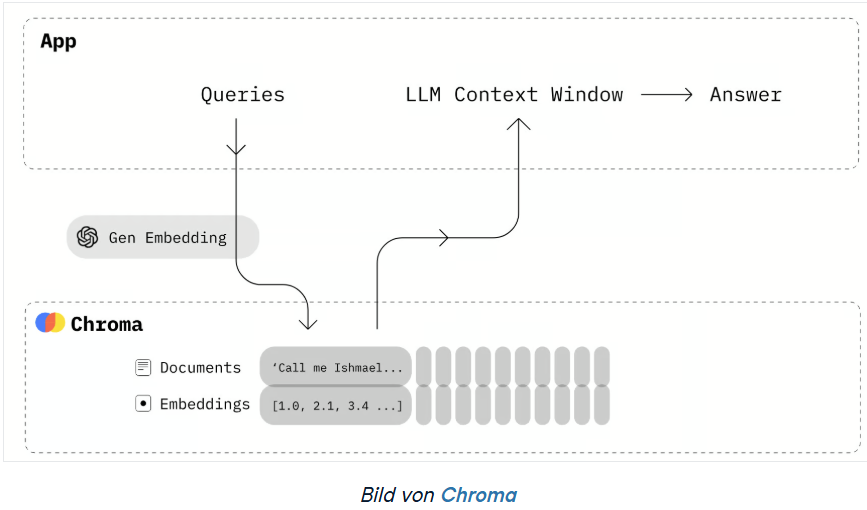

<p><font color='black' size="5">
Laden und Abfragen von ChromaDB
</font></p>

Als Beispiel für das Laden und Abfragen von ChromeDB wird der **SQuAD**-Datensatz von HuggingFace verwendet. **SQuAD** (Stanford Question Answering Dataset) ist ein beliebter Datensatz für das maschinelle Verständnis von Texten. Er enthält über ca. 100k Fragen, die auf Absätze aus Wikipedia-Artikeln basieren. Die Fragen sind so gestaltet, dass die Antwort direkt aus dem Text abgeleitet werden muss.

[SQuAD](https://huggingface.co/datasets/rajpurkar/squad)

In [ ]:
# Lesen der Datensätze von Hugging Face
import pandas as pd
splits = {'train': 'plain_text/train-00000-of-00001.parquet', 'validation': 'plain_text/validation-00000-of-00001.parquet'}

df_train = pd.read_parquet("hf://datasets/rajpurkar/squad/" + splits["train"])
df_val = pd.read_parquet("hf://datasets/rajpurkar/squad/" + splits["validation"])

df = pd.concat([df_train, df_val])

In [ ]:
df.head()

In [ ]:
# Anzahl der Datensätze je Titel im DataFrame
title_counts = df['title'].value_counts()
title_counts

Zunächst wird ein ChromaDB-Client erstellt sowie eine Sammlung mit der Bezeichnung `squad_collection` angelegt. Der standardmäßige Chroma-Client arbeitet flüchtig, was bedeutet, dass keine Speicherung auf der Festplatte erfolgt. Wie diese Daten gesichert werden können, wird nachfolgende behandelt. Die neu erstellte Chroma-Sammlung dient der Speicherung des Fragen-Kontext.

In [ ]:
import chromadb
from chromadb.utils.embedding_functions import create_langchain_embedding
from langchain_openai import OpenAIEmbeddings

embeddings_model = OpenAIEmbeddings(model="text-embedding-3-small")
embedding_function = create_langchain_embedding(embeddings_model)

client = chromadb.PersistentClient(path="./chroma-data")
collection = client.get_or_create_collection(name="squad_collection",
                                            embedding_function=embedding_function)

Zur Reduktion des Verarbeitungsaufwands werden als nächstes werden 100 zufällig ermittelte Datensätze (nur Spalte `context`) für dieses Beispiel ausgewählt und gespeichert.

In [ ]:
# Zufällige Auswahl von 100 Datensätze aus dem dataset
sampled_df = df.sample(n=100, random_state=42)

sampled_dataset = sampled_df['context']

print("Anzahl der Datensätze: ", len(sampled_dataset))
print(sampled_dataset.head())

In [ ]:
# Übernahme dieser Datensätze in den Vektorstore
for i, record in sampled_dataset.items():
    collection.add(
        ids=[str(i)],  # Use the index as the ID
        documents=[record],
        metadatas=[{"type": "context"}],
    )

Erstellen eines `test_dataset` mit Index und 10 zufällig ermittelten Fragen aus dem `sample_dataset`.

In [ ]:
test_dataset = df.iloc[sampled_dataset.sample(10).index]

In [ ]:
test_dataset = test_dataset[['question']]

Zu den Fragen werden die im Vektorstore hinterlegten Kontexte gesucht. Anschliessend erfolgt ein Vergleich zwischen dem gefundenen Kontext im RAG-System und dem Kontext im Dataset.

In [ ]:
display(Markdown("## ✨ Vergleich RAG-System vs Dataset"))
display(Markdown(f"---"))

for index, row in test_dataset.iterrows():
    result = collection.query(
        query_texts=row['question'],
        n_results=1,
    )

    display(Markdown(f"**Question:** {row['question']}"))
    display(Markdown(f"**RAG:** {result['documents'][0][0]}"))
    display(Markdown(f"**Dataset:** {sampled_dataset.loc[index]}"))
    if result['documents'][0][0] == sampled_dataset.loc[index]:
        display(Markdown(f"#### ✅ MATCH"))
    else:
        display(Markdown(f"#### ❌ NO MATCH"))
    display(Markdown(f"---"))


# 5 | RAG - Biografien
---

Retrieval-Augmented Generation (RAG) ist eine innovative Methode zur Verbesserung großer Sprachmodelle (LLMs), indem externe Daten in den Generierungsprozess eingebunden werden. Damit RAG optimal funktioniert, muss es Informationen nutzen, die nicht bereits im Basismodell enthalten sind. Dies ist besonders wichtig, da der größte Vorteil von RAG darin liegt, gezielt aktuelle oder spezialisierte Daten abzurufen, die während des ursprünglichen Trainingsprozesses nicht berücksichtigt wurden.

Diese Eigenschaft macht RAG besonders nützlich für Unternehmen, da sie große Mengen interner und proprietärer Daten verwalten, darunter Geschäftsdokumente, Kundendaten und detaillierte Berichte. Da diese Informationen in der Regel nicht öffentlich zugänglich sind, wären sie ohne RAG nicht für ein LLM nutzbar. Durch den Einsatz dieser Technik können Unternehmen ihre eigenen Daten einbinden, um genauere und relevantere Antworten zu generieren, was Entscheidungsprozesse optimiert und die betriebliche Effizienz steigert.

Zur Veranschaulichung der RAG-Fähigkeiten dient ein eigens erstellter Beispieldatensatz mit synthetischen Biografien von Forscher:innen aus unterschiedlichen Forschungsgebieten. Dieser Datensatz demonstriert, wie RAG gezielt Informationen abruft, die ein Basismodell von sich aus nicht enthalten würde, und diese in den Antwortprozess integriert. Damit wird ein praxisnaher Anwendungsfall für den Einsatz von RAG in Unternehmen dargestellt.

In [ ]:
# Abschnitt 1: Importe
# Standardbibliotheken
import os
import re
import warnings

# Drittanbieterbibliotheken
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_community.document_loaders import (
    UnstructuredMarkdownLoader,
    UnstructuredWordDocumentLoader,
    PyPDFLoader,
    UnstructuredFileLoader
)
from langchain.document_loaders import DirectoryLoader, PyPDFLoader
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
from langchain_chroma import Chroma

from langchain import hub

# Warnungen ausschalten
warnings.filterwarnings('ignore')

In [ ]:
# Abschnitt 2: Konstante
# Modell
MODEL = 'gpt-4o-mini'
EMB_MODEL = "text-embedding-3-small"

CHUNK_SIZE = 900
CHUNK_OVERLAP = 300

# Verzeichnisse
DIRECTORY_PATH = "/content/files"
PERSIST_DIRECTORY = "/content/chroma_db"

# Loader-Konfiguration
LOADER_MAPPING = {
    "*.md": UnstructuredMarkdownLoader,
    "*.docx": UnstructuredWordDocumentLoader,
    "*.pdf": PyPDFLoader,
    "*.txt": UnstructuredFileLoader,  # Loader für .txt Dateien
}

# Chat-Verlauf initialisieren
chat_history = []


Die Funktion verarbeitet ein großes Dokument, indem sie es in kleinere, handhabbare Segmente, sogenannte Chunks, unterteilt, um Einbettungen für den LLM-Abruf in Retrieval-Augmented Generation (RAG) zu erstellen. Der Chunk-Parameter bestimmt die maximale Länge jedes Segments und stellt sicher, dass der Text in Teile zerlegt wird, die vom Sprachmodell effizient verarbeitet und analysiert werden können. Der Overlap-Parameter gibt die Anzahl der Token an, die am Anfang jedes neuen Chunks wiederholt werden sollen, wodurch eine Überlappung zwischen aufeinanderfolgenden Chunks entsteht. Diese Überlappung hilft dabei, die kontextuelle Kontinuität über Chunks hinweg aufrechtzuerhalten und verbessert so die Qualität und Genauigkeit der Einbettungen. Durch die systematische Segmentierung des Dokuments und die Generierung von Einbettungen für jeden Chunk verbessert die Funktion die Fähigkeit des Sprachmodells, relevante Informationen abzurufen, was zu präziseren und kontextuell angemessenen Antworten im RAG-Framework führt.

Textdateien mit Biografielisten werden verarbeitet, indem sie in handhabbare Blöcke unterteilt werden. Eine Blockgröße von 1000 Token erleichtert dem Sprachmodell die Erstellung von Einbettungen, während eine Überlappung von 200 Token den Kontext zwischen den Blöcken erhält.

In [ ]:
!rm -rf files
!mkdir files
!curl -L https://raw.githubusercontent.com/ralf-42/GenAI/main/02%20data/biografien_1.txt -o files/biografien_1.txt
!curl -L https://raw.githubusercontent.com/ralf-42/GenAI/main/02%20data/biografien_2.md -o files/biografien_2.md
!curl -L https://raw.githubusercontent.com/ralf-42/GenAI/main/02%20data/biografien_3.pdf -o files/biografien_3.pdf
!curl -L https://raw.githubusercontent.com/ralf-42/GenAI/main/02%20data/biografien_4.docx -o files/biografien_4.docx

In [ ]:
# Funktion zum Laden der Dokumente
def load_documents_from_directory(directory_path):
    """Lädt Dokumente aus dem angegebenen Verzeichnis basierend auf den unterstützten Dateitypen."""
    documents = []
    for file_pattern, loader_cls in LOADER_MAPPING.items():
        loader = DirectoryLoader(directory_path, glob=file_pattern, loader_cls=loader_cls)
        documents.extend(loader.load())
    return documents

# Dokumente laden
documents = load_documents_from_directory(DIRECTORY_PATH)

Die geladenen Biografiedaten werden in die ChromaDB-Datenbank integriert. ChromaDB setzt standardmäßig das Einbettungsmodell `all-MiniLM-L6-v2` ein, wobei auch andere [Model Wrapper](https://docs.trychroma.com/integrations/openai) zur Verfügung stehen. Um die Dokumente in verarbeitbare Segmente zu unterteilen, kommt der RecursiveCharacterTextSplitter aus der Bibliothek langchain_text_splitters zum Einsatz. Für die Einbettungsfunktionen wird das Modell über SentenceTransformerEmbeddings instanziiert. Chroma dient als Vektorspeicher und arbeitet nahtlos mit diesen Komponenten zusammen, um Einbettungen effizient zu speichern und abzufragen.

In [ ]:
# Text-Splitter konfigurieren und Dokumente aufteilen
text_splitter = RecursiveCharacterTextSplitter(chunk_size=CHUNK_SIZE, chunk_overlap=CHUNK_OVERLAP)
docs = text_splitter.split_documents(documents)

In [ ]:
type(docs), len(docs)

In [ ]:
# Embeddingsmodell festlegen
embeddings = OpenAIEmbeddings(model=EMB_MODEL)

In [ ]:
# Vektordatenbank erstellen und speichern
vectorstore = Chroma.from_documents(docs, embeddings, persist_directory=PERSIST_DIRECTORY)

Hier wird ein vordefinierter Prompt für RAG-Anwendungen aus dem LangChain Hub geladen. "rlm/rag-prompt" ist ein spezieller Prompt, der für Retrieval-Augmented Generation optimiert ist.


[LangChainHub](https://smith.langchain.com/hub/rlm/rag-prompt)

In [ ]:
rag_prompt = hub.pull("rlm/rag-prompt")

Diese Funktion nimmt eine Liste von Dokumentobjekten (wie sie vom Retriever zurückgegeben werden) und:

+ Extrahiert den Textinhalt (page_content) aus jedem Dokument
+ Verbindet alle Textinhalte mit doppelten Zeilenumbrüchen zu einem einzigen String
+ Dies ist wichtig, um die abgerufenen Dokumente in ein Format zu bringen, das dem LLM als Kontext übergeben werden kann

In [ ]:
def format_documents(documents):
    return "\n\n".join(doc.page_content for doc in documents)

Hier werden zwei Hauptkomponenten initialisiert:

+ Ein Large Language Model (LLM) mit OpenAI
+ Ein Retriever, der aus einem vectorstore erstellt wird (der vorher im Code definiert wurde)

Dieser Retriever sucht relevante Dokumente aus dem Vektorspeicher basierend auf Ähnlichkeit zur Abfrage

In [ ]:
# Festlegen LLM und Retriever
llm = ChatOpenAI(model=MODEL, temperature=0)
retriever = vectorstore.as_retriever()

Hier wird die komplette RAG-Pipeline zusammengebaut:

Eingabe-Dictionary wird erstellt mit:

+ "context": Führt zuerst den Retriever aus, um relevante Dokumente zu finden, und formatiert diese dann mit der format_documents-Funktion
+ "question": Leitet die ursprüngliche Frage unverändert weiter (mittels RunnablePassthrough())


Dieses Dictionary wird an den RAG-Prompt übergeben (rag_prompt), der ein Template mit Platzhaltern für Kontext und Frage ist
Der formatierte Prompt wird an das LLM übergeben (llm), das eine Antwort basierend auf der Frage und dem bereitgestellten Kontext generiert
Die LLM-Ausgabe wird durch den StrOutputParser() geleitet, um sie in einen einfachen String zu konvertieren

Die gesamte Pipeline ermöglicht es, eine Frage zu stellen, relevante Dokumente zu finden, diese mit der Frage zu kombinieren und eine fundierte Antwort zu generieren, die auf den abgerufenen Informationen basiert.

In [ ]:
qa_chain = (
    {"context": retriever | format_documents, "question": RunnablePassthrough()}
    | rag_prompt
    | llm
    | StrOutputParser()
)

Die RAG-Kette kann nun aufgerufen werden, um Informationen zu einer der in den Beispielbiografiedaten enthaltenen Personen abzurufen.

In [ ]:
query = "Was macht Tariq Hassan?"
result = qa_chain.invoke(query)

display(Markdown("### 🧑 Mensch:"))
display(Markdown(query))
display(Markdown("### 🤖 KI:"))
display(Markdown(result))

In [ ]:
query = "Welche Bio-Daten sind zu Elara Fontaine verfügbar?"
result = qa_chain.invoke(query)

display(Markdown("### 🧑 Mensch:"))
display(Markdown(query))
display(Markdown("### 🤖 KI:"))
display(Markdown(result))

# 6 | Optinal: ChromaDB als Server
---

In diesem Abschnitt wird erläutert, wie ChromaDB als **Server** betrieben werden kann, um den Zugriff auf ein RAG-LLM zu ermöglichen.

Die Verwendung eines VectorStore-Clients wie ChromaDB über HTTP gegenüber einer lokalen Festplattenspeicherung bietet mehrere wichtige Vorteile:

**Vorteile eines VectorStore als Client (z.B. ChromaDB über HTTP)**

+ **Skalierbarkeit:** Der Client-Server-Ansatz ermöglicht die Skalierung über die Grenzen eines einzelnen Rechners hinaus Mehrere Anwendungen können gleichzeitig auf dieselbe Vektordatenbank zugreifen


+ **Persistenz und Zuverlässigkeit:** Die Daten bleiben erhalten, auch wenn die Client-Anwendung abstürzt
Der Server kann Sicherungen und Replikation implementieren


+ **Ressourcentrennung:**Rechenintensive Vektoroperationen werden auf dem Server ausgeführt
Entlastung der Client-Anwendung von speicherintensiven Operationen


+ **Unabhängigkeit:** Der ChromaDB-Server kann unabhängig von deiner Anwendung aktualisiert oder gewartet werden
Verschiedene Clients können in unterschiedlichen Programmiersprachen implementiert sein



**Nachteile gegenüber lokaler Speicherung**

+ **Latenz:** HTTP-Anfragen fügen eine gewisse Verzögerung hinzu Netzwerkprobleme können die Zuverlässigkeit beeinträchtigen


+ **Komplexität:** Die Einrichtung und Wartung eines Servers erfordert zusätzlichen Aufwand
Erfordert mehr Infrastrukturkenntnis

<p><font color='black' size="5">
Datenbank als Server ausführen
</font></p>


Der folgende Code zeigt die Struktur der Datenbank, wie sie von ChromaDB gespeichert wird.

In [ ]:
!ls -al /content/chroma_db


Der folgende Befehl startet einen ChromaDB-Server, der das zuvor festgelegte Verzeichnis nutzt.

**Unix-Befehl:**

```
chroma run --host 127.0.0.1 --path /content/chroma_db &
```

In [ ]:
import chromadb # Vor Ausführung des Unix-Befehls

In [ ]:
!uv pip install --system -q colab-xterm
%load_ext colabxterm

In [ ]:
%xterm

Wir können jetzt einen Client erstellen, um mit diesem Datenbankserver zu kommunizieren.

In [ ]:
import langchain_community
from langchain_community.vectorstores import Chroma

client = chromadb.HttpClient(host='127.0.0.1', port=8000)
vectorstore_new = langchain_community.vectorstores.chroma.Chroma(
    client=client,embedding_function=embeddings)

Der folgende Code (siehe oben) zeigt, dass die HTTP-Datenbank des Clients betriebsbereit ist.

In [ ]:
retriever_new = vectorstore_new.as_retriever()

qa_chain = (
    {"context": retriever_new | format_documents, "question": RunnablePassthrough()}
    | rag_prompt
    | llm
    | StrOutputParser()
)

Wir führen eine Abfrage durch, die auf die RAG-fähigen Daten zugreift.

In [ ]:
query = "Wer ist Amina Diallo und was macht sie?"
result = qa_chain.invoke(query)

display(Markdown("### 🧑 Mensch:"))
display(Markdown(query))
display(Markdown("### 🤖 KI:"))
display(Markdown(result))


# A | Aufgabe
---

Die Aufgabestellungen unten bieten Anregungen, Sie können aber auch gerne eine andere Herausforderung angehen.

<p><font color='black' size="5">
RAG zum LLM-Buch
</font></p>

Erstelle Sie ein RAG, um das LLM die ihr eigenes LLM-Buch aus Modul 05 lesen und analysieren zu lassen.

Lassen Sie mehrere Fragen beantworten. Die Antworten sollten so einfach wie möglich sein, z. B. „ja/nein“, der Name einer Stadt oder eine kurze Rollenbeteichnung. Stelle die Ergebnisse in einer Tabelle im Markdown-Format dar.



<p><font color='black' size="5">
Einfache RAG-Evaluation
</font></p>

Bewerten Sie, wie gut ein RAG-System eine bestimmte Frage beantworten kann.
Aufgabe:

+ Erstellen Sie einen kleinen Datensatz mit Informationen zu einem bekannten Thema (z.B. ein Filmzusammenfassung)
+ Formulieren Sie drei konkrete Fragen und die erwarteten Antworten
+ Implementiere einen RAG-Workflow und teste, wie gut die Antworten mit deinen Erwartungen übereinstimmen


Beispiel:


> **Filmzusammenfassung als Beispiel**   
film_text = """   
Der Herr der Ringe: Die Gefährten" ist ein Fantasy-Film aus dem Jahr 2001, basierend auf dem ersten Band von J.R.R. Tolkiens Trilogie.
Der Film handelt von dem Hobbit Frodo Beutlin, der einen mächtigen Ring erbt.
Der Zauberer Gandalf entdeckt, dass es sich um den Einen Ring des dunklen Herrschers Sauron handelt.
Um Mittelerde zu retten, muss der Ring im Feuer des Schicksalsberges in Mordor zerstört werden.
Frodo macht sich zusammen mit acht Gefährten auf die gefährliche Reise: dem Zauberer Gandalf, den Menschen Aragorn und Boromir, dem Elben Legolas, dem Zwerg Gimli und den Hobbits Sam, Merry und Pippin.
Regie führte Peter Jackson. Der Film gewann vier Oscars.   
"""



